In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA

In [2]:
dataset = fetch_olivetti_faces(shuffle=True, random_state=101)

# Train / test split
train_faces = dataset.data[:350, :]
test_faces = dataset.data[350:, :]
train_labels = dataset.target[:350]
test_labels = dataset.target[350:]

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\Joan\scikit_learn_data


Explained variance by 100 components: 0.939


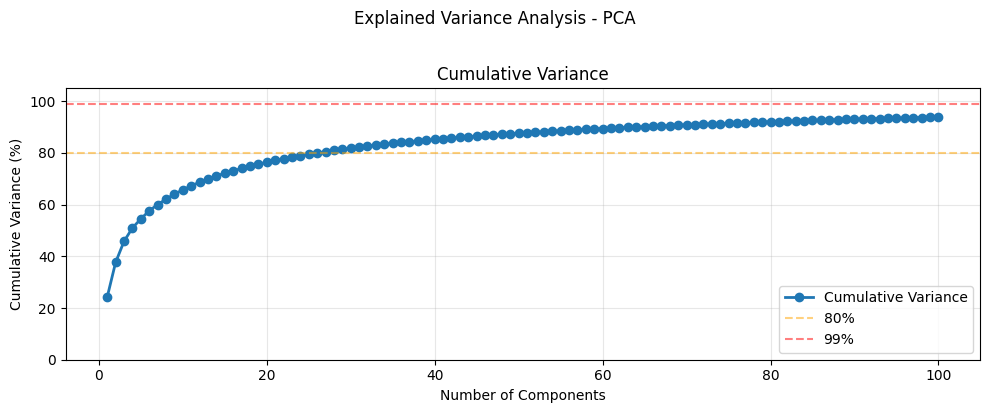

In [3]:
# PCA configuration
n_components = 100
pca = PCA(n_components=n_components, whiten=True)
pca.fit(train_faces)

explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Explained variance by {n_components} components: {explained_variance:.3f}")

# Variance DataFrame
variance_df = pd.DataFrame({
    "Component": [i+1 for i in range(n_components)],
    "Variance": pca.explained_variance_ratio_,
    "Cummulative Variance": np.cumsum(pca.explained_variance_ratio_)
})

fig1, (ax2) = plt.subplots(1,1, figsize=(10, 4))



# Line chart (cumulative variance)
ax2.plot(variance_df["Component"],
         variance_df["Cummulative Variance"] * 100,
         marker="o", linewidth=2, label="Cumulative Variance")

for threshold, color in zip([80, 99], ["orange", "red"]):
    ax2.axhline(y=threshold, color=color, linestyle="--", alpha=0.5, label=f"{threshold}%")

ax2.set_title("Cumulative Variance")
ax2.set_xlabel("Number of Components")
ax2.set_ylabel("Cumulative Variance (%)")
ax2.set_ylim(0, 105)
ax2.legend(loc="lower right")
ax2.grid(True, alpha=0.3)

plt.suptitle("Explained Variance Analysis - PCA", y=1.02)
plt.tight_layout()
plt.savefig("./figures/face_variance.png")
plt.show()

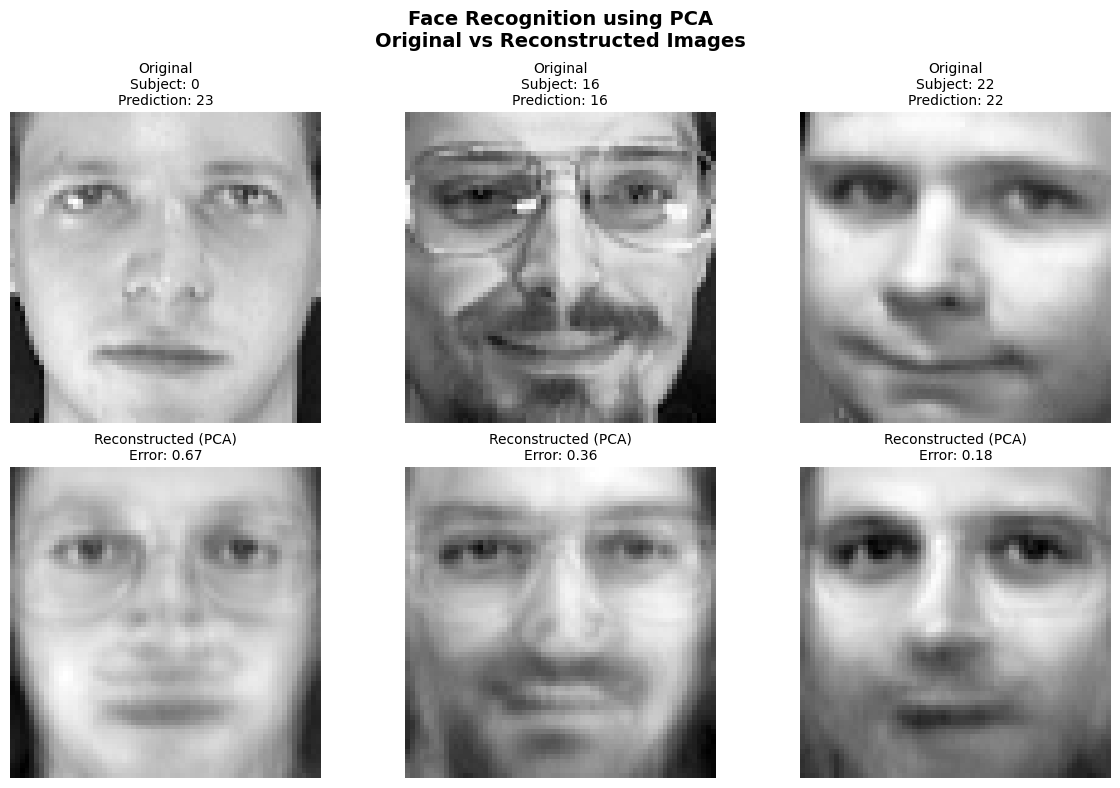

In [6]:
# PCA configuration
n_components = 30
pca = PCA(n_components=n_components, whiten=True)
pca.fit(train_faces)

compressed_train_faces = pca.transform(train_faces)
compressed_test_faces = pca.transform(test_faces)

# Random test samples
random_indices = np.random.choice(len(test_faces), size=3, replace=False)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for col, idx in enumerate(random_indices):
    # Query in PCA space
    query = compressed_test_faces[idx]

    # Nearest neighbor in PCA space
    errors = np.mean((compressed_train_faces - query) ** 2, axis=1)
    best_match = np.argmin(errors)

    # --- Original image (top row) ---
    axes[0, col].imshow(
        test_faces[idx].reshape(64, 64),
        cmap="gray",
        interpolation="nearest"
    )
    axes[0, col].axis("off")
    axes[0, col].set_title(
        f"Original\n"
        f"Subject: {test_labels[idx]}\n"
        f"Prediction: {train_labels[best_match]}",
        fontsize=10
    )

    # --- Reconstructed image from PCA (bottom row) ---
    reconstructed = pca.inverse_transform(query)

    axes[1, col].imshow(
        reconstructed.reshape(64, 64),
        cmap="gray",
        interpolation="nearest"
    )
    axes[1, col].axis("off")
    axes[1, col].set_title(
        f"Reconstructed (PCA)\nError: {errors[best_match]:.2f}",
        fontsize=10
    )

plt.suptitle("Face Recognition using PCA\nOriginal vs Reconstructed Images",
             fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig("./figures/face_results.png")
plt.show()


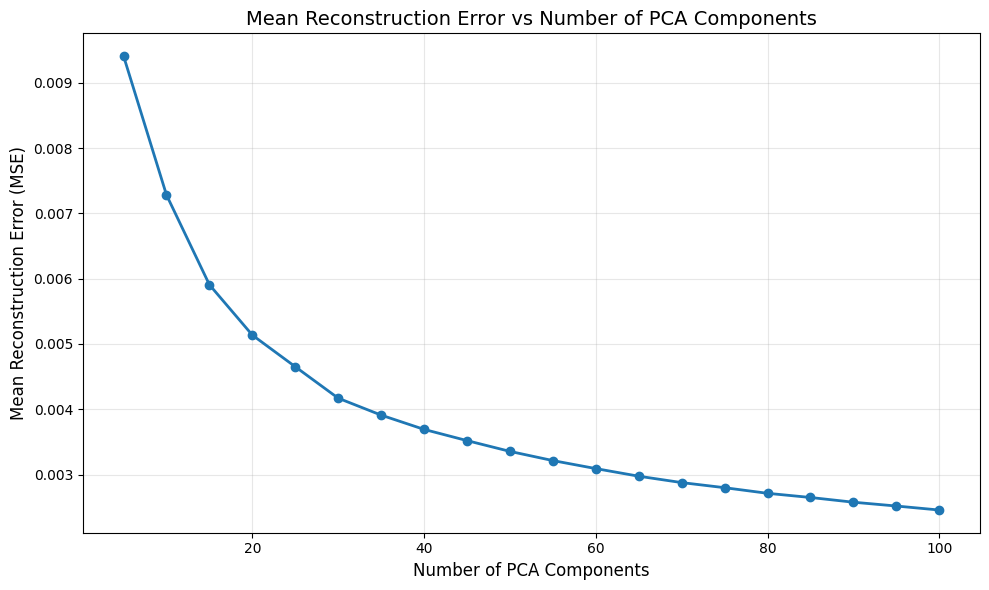

In [5]:
component_range = range(5, 101, 5)
mean_errors = []

for n in component_range:
    pca = PCA(n_components=n, whiten=True, random_state=42)
    pca.fit(train_faces)

    # Project and reconstruct test faces
    compressed_test = pca.transform(test_faces)
    reconstructed_test = pca.inverse_transform(compressed_test)

    # Mean Squared Reconstruction Error
    mse = np.mean((test_faces - reconstructed_test) ** 2)
    mean_errors.append(mse)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(component_range, mean_errors, marker='o', linewidth=2)
plt.xlabel("Number of PCA Components", fontsize=12)
plt.ylabel("Mean Reconstruction Error (MSE)", fontsize=12)
plt.title("Mean Reconstruction Error vs Number of PCA Components", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("./figures/face_errors.png")
plt.show()
